In [404]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np
import yfinance as yf
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report
from statsmodels.tsa.holtwinters import SimpleExpSmoothing,ExponentialSmoothing
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')

In [385]:
class StockPrediction():
    def __init__(self,stock_symbol="SPY",interval='1d',period='max'):
        """Initializes the class, creates the following arguments:
        stock_symbol: Ticker
        interval: period between any sample in the data 
        df: downloaded data
        
        """
        self.period=period
        self.stock_symbol = stock_symbol
        self.interval = interval
        self.df = self.download_ticker(self.stock_symbol,self.interval)
        self.train = None # train set from train_test_split
        self.test = None # test set from train_test_split
        self.d= 0

        # baseline model
        self.baseline_history = []
        self.baseline_pred = []
        self.baseline_RMSE = None
        
        # model
        self.model = None
        self.pred = []
        self.history = []
        
               
    def download_ticker(self, ticker, interval):
        """params: 
            ticker: default is SPY
            returned_cols: (list) default is Adj Close
            interval: one of 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo, default is 1d
            returns: df with ticker data index is timeseries"""
        return yf.download(ticker, interval=interval,period=self.period)
    
    def train_test_split(self, col="Adj Close",diff=0, pct_change=False, train_size=.99):
        """Splits dataframe into train and test according to train_size"""
        self.d = diff
        self.original_price = col
        ind_split=int(np.floor(len(self.df.index)*train_size))
        self.ind_split=ind_split
        # Train
        self.train= self.df.iloc[:ind_split][col] if self.d==0 else \
            (self.df.iloc[:ind_split][col].diff(self.d).dropna() if not pct_change else \
             self.df.iloc[:ind_split][col].pct_change(self.d).dropna()*100)
        # test
        self.test = self.df.iloc[ind_split:][col] if self.d==0 else \
            (self.df.iloc[ind_split:][col].diff(self.d).dropna() if not pct_change else \
             self.df.iloc[ind_split:][col].pct_change(self.d).dropna()*100)
        print("train, test split success")
            
    def baseline_predict_all(self,p=1,q=1,diff=False):
        self.baseline_pred = []
        self.baseline_history = self.train.to_list()
        
        for t in tqdm(range(len(self.test)),total=len(self.test)):
            bsl_model = ARIMA(self.baseline_history, order = (p, q if not diff else 0 ,q))
            bsl_fit = bsl_model.fit()
            self.baseline_pred.append(bsl_fit.forecast()[0])
            self.baseline_history.append(self.test[t])
        self.baseline_RMSE = np.sqrt(((self.test.to_numpy() - np.array(self.baseline_pred))**2).sum()/len(self.test.index))
        
    def baseline_predict(self, scope=1, p=4, q=1):
        baseline_model = ARIMA(pd.concat([self.train,self.test]), order=(p, q if not diff else 0, q))
        bsl_fit = baseline_model.fit()
        return pd.Series(bsl_fit.forecast(steps = scope))
    
    def plot_baseline_performance(self):
        plt.figure(figsize=(12,8))
        ax = self.test.plot(label="y_true")
        pd.Series(self.baseline_pred,index=self.test.index).plot(label="y_pred_baseline", ax = ax)
        ax.grid(True, which="both")
        ax.legend()
        ax.set_title(f"RMSE_Baseline: {self.baseline_RMSE:.4f}")
        
        
    def exp_predict_all(self):
        """Makes exponantial smoothing predictions for all test set, adds it as a new attribute: self.exp_preds"""
        exp_pred = pd.Series()
        exp_history = self.train.to_list()

        for t in range(len(spy.test)):
            exp_model = SimpleExpSmoothing(exp_history,initialization_method='estimated')
            exp_fit = exp_model.fit()
            exp_pred[self.test.index[t]]=exp_fit.forecast()[0]
            exp_history.append(self.test[t])
        self.exp_preds=exp_pred
        self.exp_RMSE=mean_squared_error(self.test,self.exp_preds,squared=False)        
        
    def exp_predict(self):
        """Makes Unique prediction for the next period"""
        exp_model = SimpleExpSmoothing(self.df['Adj Close'],initialization_method='estmiated').fit()
        return pd.Series(exp_model.forecast())
    
    def avg_predict_all(self,window=5):
        """Makes predictions based on the average method, parameter window is the number of sample used for the prediction"""
        self.avg_preds=self.df['Adj Close'].iloc[self.ind_split-window+1:].rolling(window=window).mean().dropna()
    
    def profiling(self,cols=["Adj Close"]):
        """Automatic EDA"""
        # head
        print("The head of the DataFrame:")
        display(self.df.head())
        print("\n")
        
        # shape
        print("The shape of the DataFrame:")
        display(self.df.shape)
        print("\n")
        
        # index
        print("The time stamp for each record:")
        display(self.df.index)
        print("\n")
        
        # plot the distribution of the day
        print("The distribution of the weekday recorded:")
        sns.countplot(x=self.df.index.strftime('%A'))
        plt.show()
        print("\n")
        
        # gap
        print("The start date and the current end date for the data:")
        display(self.df.index[0],self.df.index[-1])
        print("\n")
        
        # nan check
        print("If there is missing values in the data:")
        display(self.df.isna().sum())
        print("\n")
        
        # describe
        print("Describe the time series:")
        display(self.df.describe())
        print("\n")
        
        for col in cols:
            # plot time series values
            print("Plot the time series:")
            plt.figure(figsize=(12,8))
            self.plot(col)
            plt.title = f"{col} Price"
            plt.show()
            
            # plot diff one day
            print("Plot the change in the time series:")
            plt.figure(figsize=(12,8))
            self.df[col].diff().plot()
            plt.title = f"{col} Price Change"
            plt.show()
            # plot diff acf
            print(f"Plot the Auto-Correlation Function of {col} Price Change:")
            self.plot_acf(col)
            plt.show()
            # plot diff pacf
            print(f"Plot the Partial Auto-Correlation Function of {col} Price Change:")
            self.plot_pacf(col)
            plt.show()
            
    def plot(self,col="Adj Close"):
        self.df[col].plot()
        
    def plot_acf(self,col="Adj Close"):
        plot_acf(self.df[col].diff().dropna())
        
    def plot_pacf(self,col="Adj Close"):
        plot_pacf(self.df[col].diff().dropna())
    

In [386]:
spy=StockPrediction(interval='1h',period='2y')

[*********************100%***********************]  1 of 1 completed


In [387]:
spy.df

,Open,High,Low,Close,Adj Close,Volume
2020-06-24 09:30:00-04:00,309.839996,310.510010,307.000000,308.269989,308.269989,18319314
2020-06-24 10:30:00-04:00,308.260010,308.265015,304.290009,304.970001,304.970001,18480031
2020-06-24 11:30:00-04:00,304.989990,305.119995,302.119995,304.089996,304.089996,24301499
2020-06-24 12:30:00-04:00,304.079987,305.500000,303.630005,303.890015,303.890015,10008342
2020-06-24 13:30:00-04:00,303.890015,304.660004,302.779999,304.549988,304.549988,10519955
...,...,...,...,...,...,...
2022-06-23 12:30:00-04:00,374.619995,374.869995,372.890015,373.899994,373.899994,9172795
2022-06-23 13:30:00-04:00,373.880005,375.600006,373.309998,375.500000,375.500000,7566208
2022-06-23 14:30:00-04:00,375.519989,377.190002,375.470001,376.950012,376.950012,8528875
2022-06-23 15:30:00-04:00,376.929993,378.829987,376.929993,378.109985,378.109985,10284798


In [388]:
spy.train_test_split(train_size=.8)

train, test split success


In [389]:
spy.exp_predict_all()

In [471]:
class Invest_shorten():
    def __init__(self,true_adj_close,preds=None,pred_recs=None):
        """The class receives the true proces of the stock and the predictions of prices"""
        self.daily_table=pd.DataFrame() #Initializes the table
        self.daily_table['Adj_close']=true_adj_close #Adds the true prices
        if preds is not None:
            self.daily_table['preds']=preds #Adds predictions
            self.daily_table['pred_rec']=(self.daily_table['Adj_close'].shift(1)<self.daily_table.preds).astype(int) # Makes recommandation based on predictions
        else:
            self.daily_table['pred_rec']=pred_recs # Makes recommandation based on imput pred_recs
        self.daily_table['profit_day']=self.daily_table['Adj_close'].pct_change()  #Checks for stocks profit on this day
        self.daily_table['profit_pred']=np.select([self.daily_table.pred_rec==1,self.daily_table.pred_rec==0],[self.daily_table.profit_day,0])+1 #Constructs system profit based on stock profit and recommandation
        self.daily_table.iloc[0,-1]=self.daily_table['Adj_close'].iloc[0] #Initialises the initial money as initial stock price
        self.daily_table['money_end_day']=np.cumprod(self.daily_table.profit_pred)
        
    def plot_money_end_day_evolution(self):
        """Plots the total amount of money of stock vs prediction based"""
        plt.figure(figsize=(13,10))
        self.daily_table['Adj_close'].plot(label='True prices')
        self.daily_table.money_end_day.plot(label='Preds')
        plt.legend();
    
    def plot_daily_pct_change(self):
        plt.figure(figsize=(13,10))
        self.daily_table.profit_day.plot(label='true changes')
        plt.plot(self.daily_table.profit_pred[1:]-1,label='Preds')
        plt.legend();
    
    def make_summary_table(self):
        summary=pd.DataFrame()
        summary['RMSE']=[mean_squared_error(self.daily_table.Adj_close,self.daily_table.preds,squared=False) if 'preds' in self.daily_table.columns else None ]
        summary['Stock_return']=[(self.daily_table.Adj_close.iloc[-1]/self.daily_table.Adj_close.iloc[0])-1]
        summary['System_return']=[(self.daily_table.money_end_day.iloc[-1]/self.daily_table.money_end_day[0])-1]
        self.true_recommandations=(self.daily_table['Adj_close'].shift(1)<self.daily_table['Adj_close']).astype(int)
        summary['Recommandation_accuracy']=[accuracy_score(self.true_recommandations,self.daily_table.pred_rec)]
        return summary

# Money from Exponantial smoothing predictions

In [472]:
money_from_exp=Invest_shorten(spy.test,spy.exp_preds)

In [473]:
money_from_exp.make_summary_table()

,RMSE,Stock_return,System_return,Recommandation_accuracy
0,2.377394,-0.126055,-0.095688,0.477273


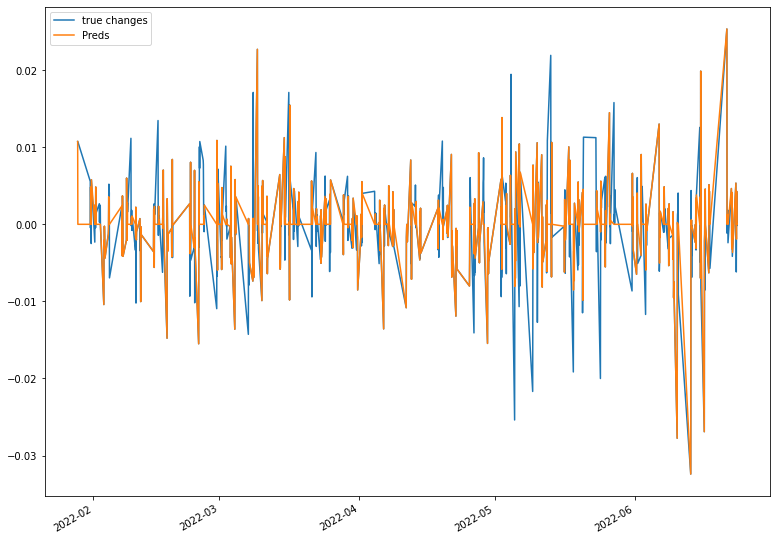

In [474]:
money_from_exp.plot_daily_pct_change()

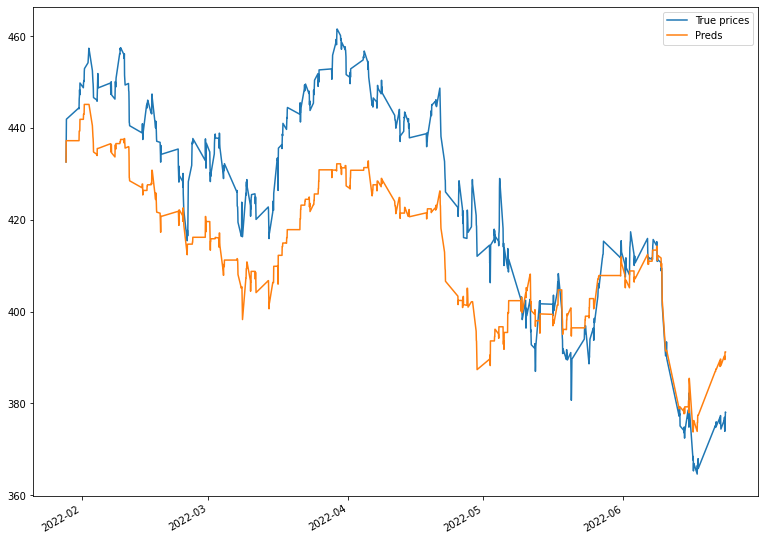

In [475]:
money_from_exp.plot_money_end_day_evolution()

# Average method

In [476]:
spy.avg_predict_all()

In [477]:
spy.avg_preds

2022-01-28 13:30:00-05:00    433.885999
2022-01-28 14:30:00-05:00    435.191357
2022-01-28 15:30:00-05:00    436.575360
2022-01-31 09:30:00-05:00    438.349359
2022-01-31 10:30:00-05:00    440.060358
                                ...    
2022-06-23 12:30:00-04:00    375.250006
2022-06-23 13:30:00-04:00    375.472003
2022-06-23 14:30:00-04:00    375.584003
2022-06-23 15:30:00-04:00    375.815997
2022-06-23 16:00:00-04:00    376.503998
Name: Adj Close, Length: 704, dtype: float64

In [478]:
money_avg=Invest_shorten(spy.test,spy.avg_preds)

In [479]:
money_avg.make_summary_table()

,RMSE,Stock_return,System_return,Recommandation_accuracy
0,2.670295,-0.126055,0.370072,0.526989


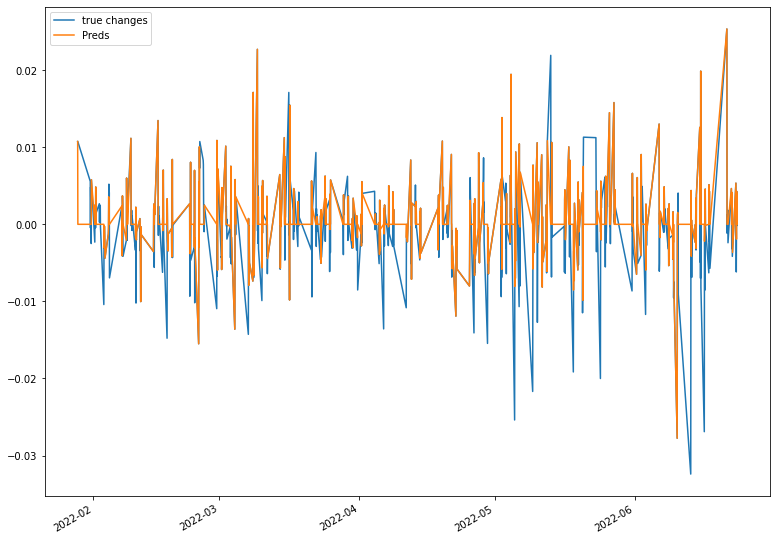

In [480]:
money_avg.plot_daily_pct_change()

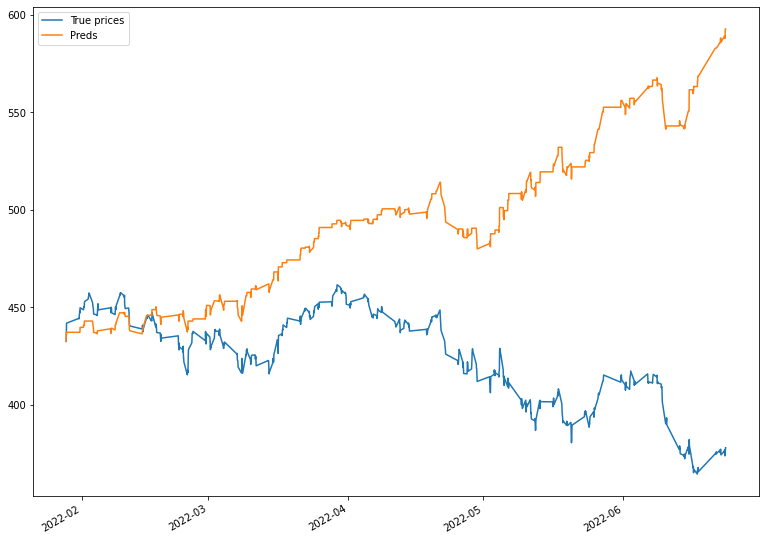

In [481]:
money_avg.plot_money_end_day_evolution()

In [482]:
print(classification_report(money_avg.true_recommandations,money_avg.daily_table.pred_rec))

              precision    recall  f1-score   support

           0       0.56      0.51      0.53       375
           1       0.49      0.55      0.52       329

    accuracy                           0.53       704
   macro avg       0.53      0.53      0.53       704
weighted avg       0.53      0.53      0.53       704



# Intersection prediction of Exp and Average strategy

In [483]:
inter_preds=money_avg.daily_table.pred_rec.where((money_from_exp.daily_table.pred_rec==1)&(money_avg.daily_table.pred_rec==1),other=0)

In [484]:
inter_money=Invest_shorten(spy.test,pred_recs=inter_preds)

In [485]:
inter_money.make_summary_table()

,RMSE,Stock_return,System_return,Recommandation_accuracy
0,None,-0.126055,0.174647,0.519886


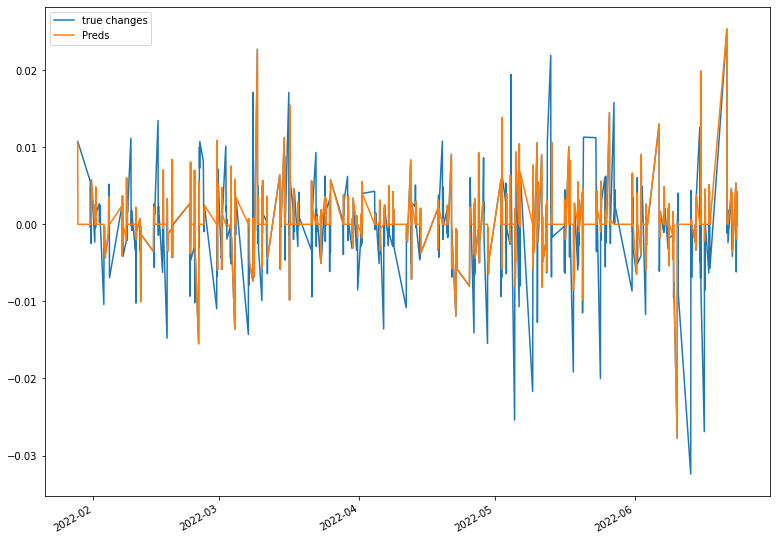

In [486]:
inter_money.plot_daily_pct_change()

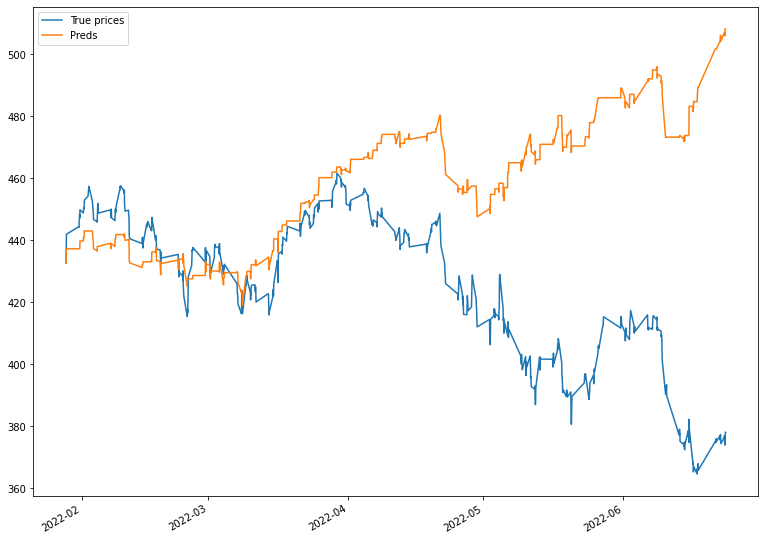

In [487]:
inter_money.plot_money_end_day_evolution()

In [488]:
inter_money.daily_table

,Adj_close,pred_rec,profit_day,profit_pred,money_end_day
2022-01-28 13:30:00-05:00,432.589996,0,NaN,432.589996,432.589996
2022-01-28 14:30:00-05:00,437.236786,1,0.010742,1.010742,437.236786
2022-01-28 15:30:00-05:00,441.920013,0,0.010711,1.000000,437.236786
2022-01-31 09:30:00-05:00,444.380005,0,0.005567,1.000000,437.236786
2022-01-31 10:30:00-05:00,444.174988,0,-0.000461,1.000000,437.236786
...,...,...,...,...,...
2022-06-23 12:30:00-04:00,373.899994,1,-0.001922,0.998078,505.975225
2022-06-23 13:30:00-04:00,375.500000,1,0.004279,1.004279,508.140412
2022-06-23 14:30:00-04:00,376.950012,0,0.003862,1.000000,508.140412
2022-06-23 15:30:00-04:00,378.109985,0,0.003077,1.000000,508.140412
